In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl
quandl.ApiConfig.api_key = "K42xtcTyEM7To-P_MwmN"
import torch.nn as nn
import torch
from torch.autograd import Variable
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# Globals

INPUT_SIZE = 60
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1

# Hyper parameters

learning_rate = 0.001
num_epochs = 50











In [140]:
# Importing the data set
dataset_train = quandl.get("WIKI/NVDA")
training_set = dataset_train.iloc[:, 0:1].values

# set a numeric id for use as an index for examples.
#dataset_train['id'] = [x for x in range(dataset_train.shape[0])] 
#dataset_train.set_index('id', inplace=True)   # Change the index to be based on the 'id' column
#training_set =dataset_train.loc[:4459, ['Open'] ] #select all the data besides the last 365 days  to be used as training

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [141]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(INPUT_SIZE, len(training_set)):
    X_train.append(training_set_scaled[i-INPUT_SIZE:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])) #reshape data as 1-120, 2-121, 3-123 e.t.c for later purpose.

In [142]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(          #initialize the parameters
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1) #size(-1) refers to the last dimension of the tensor
        r_out = r_out.view(-1, hidden_size) #reshape the r_out, dont care row as long as it fit hidden_size
        outs = self.out(r_out)

        return outs, hidden_state

In [143]:
rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
rnn = rnn.to(DEVICE)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate) #use adam optimizer
criterion = nn.MSELoss() #use MSE to back propagate

hidden_state = None



In [144]:
for epoch in range(num_epochs):
    inputs = Variable(torch.from_numpy(X_train).float())
    labels = Variable(torch.from_numpy(y_train).float())

    output, hidden_state = rnn(inputs, hidden_state) 

    loss = criterion(output.view(-1), labels)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)                     # back propagation
    optimiser.step()                                     # update the parameters
    
    print('epoch {}, loss {}'.format(epoch,loss.item()))

epoch 0, loss 0.05101789906620979
epoch 1, loss 0.03943696245551109
epoch 2, loss 0.029855160042643547
epoch 3, loss 0.022028475999832153
epoch 4, loss 0.015883075073361397
epoch 5, loss 0.011537829414010048
epoch 6, loss 0.0092365937307477
epoch 7, loss 0.008976812474429607
epoch 8, loss 0.009962109848856926
epoch 9, loss 0.010700947605073452
epoch 10, loss 0.010095174424350262
epoch 11, loss 0.008206455036997795
epoch 12, loss 0.005847758147865534
epoch 13, loss 0.003829141380265355
epoch 14, loss 0.0025767905171960592
epoch 15, loss 0.002113747177645564
epoch 16, loss 0.002201829804107547
epoch 17, loss 0.0025120556820183992
epoch 18, loss 0.0027693775482475758
epoch 19, loss 0.0028390148654580116
epoch 20, loss 0.0027409004978835583
epoch 21, loss 0.002603908535093069
epoch 22, loss 0.0025697993114590645
epoch 23, loss 0.0026696904096752405
epoch 24, loss 0.002781189512461424
epoch 25, loss 0.002755511552095413
epoch 26, loss 0.002552082994952798
epoch 27, loss 0.002243119524791836

C:\Users\Desmond\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


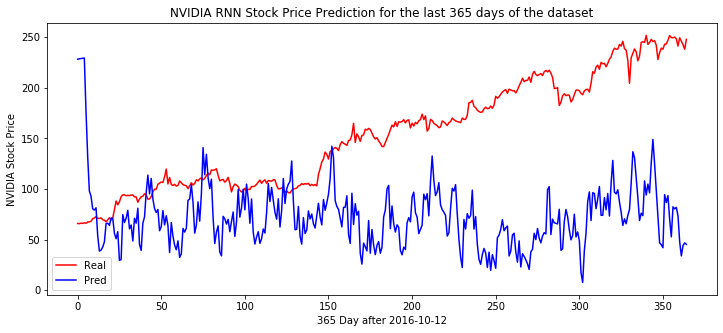

In [145]:
# Getting the real stock price of 2017
real_stock_price = dataset_train.iloc[:, 1:2][-365:].values  #getting the last 365 days data for 'Open'

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Open'], dataset_train['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(real_stock_price) - INPUT_SIZE:].values  
dataset_train2 = dataset_train.as_matrix()
inputs = dataset_train2.reshape(-1,1)
inputs = sc.transform(inputs)  #normalize data
X_test = []
for i in range(INPUT_SIZE, 420):  #60 to 420
    X_test.append(inputs[i-INPUT_SIZE:i, 0])  
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train_X_test = np.concatenate((X_train, X_test),axis=0)
hidden_state = None
test_inputs = Variable(torch.from_numpy(X_train_X_test).float())
predicted_stock_price, b = rnn(test_inputs, hidden_state)
predicted_stock_price = np.reshape(predicted_stock_price.detach().numpy(), (test_inputs.shape[0], 1))
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price_all = np.concatenate((training_set[INPUT_SIZE:], real_stock_price))

# Visualising the results
plt.figure(1, figsize=(12, 5 ))
plt.plot(training_set[-365:], color = 'red', label = 'Real')
plt.plot(predicted_stock_price[-365:], color = 'blue', label = 'Pred')
plt.title('NVIDIA RNN Stock Price Prediction for the last 365 days of the dataset')
plt.xlabel('365 Day after 2016-10-12')
plt.ylabel('NVIDIA Stock Price')
plt.legend()
plt.show()

In [113]:
len(dataset_train)

4825

In [85]:
# Model score
score = round(r2_score(training_set[-365:], predicted_stock_price[-365:])*100, 4)
accuracy= str(score)
print('Training accuracy: ' + accuracy + '%')

Training accuracy: -3201.2216%


In [86]:
#Model MSE
MSE = round(mean_absolute_error(predicted_stock_price[-365:], training_set[-365:]), 4)
MSE = str(MSE)
print('MSE: ' + MSE )

MSE: 79.759
